# Classificação: Classificador Bayesiano

Francisco Aparecido Rodrigues, francisco@icmc.usp.br.<br>
Universidade de São Paulo, São Carlos, Brasil.<br>
https://sites.icmc.usp.br/francisco<br>

Vamos inicialmente ler os dados:

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
random.seed(42) # define the seed (important to reproduce the results)

#data = pd.read_csv('data/vertebralcolumn-3C.csv', header=(0))
#data = pd.read_csv('data/BreastCancer.csv', header=(0))
#data = pd.read_csv('data/Iris.csv', header=(0))
data = pd.read_csv('data/Vehicle.csv', header=(0))

data = data.dropna(axis='rows') #remove NaN
# armazena os nomes das classes
classes = np.array(pd.unique(data[data.columns[-1]]), dtype=str)  

nrow, ncol = data.shape
print("Matriz de atributos: Número de linhas:", nrow, " colunas: ", ncol)
attributes = list(data.columns)
data.head(10)

Matriz de atributos: Número de linhas: 846  colunas:  19


,Comp,Circ,D.Circ,Rad.Ra,Pr.Axis.Ra,Max.L.Ra,Scat.Ra,Elong,Pr.Axis.Rect,Max.L.Rect,Sc.Var.Maxis,Sc.Var.maxis,Ra.Gyr,Skew.Maxis,Skew.maxis,Kurt.maxis,Kurt.Maxis,Holl.Ra,Class
0,95,48,83,178,72,10,162,42,20,159,176,379,184,70,6,16,187,197,van
1,91,41,84,141,57,9,149,45,19,143,170,330,158,72,9,14,189,199,van
2,104,50,106,209,66,10,207,32,23,158,223,635,220,73,14,9,188,196,saab
3,93,41,82,159,63,9,144,46,19,143,160,309,127,63,6,10,199,207,van
4,85,44,70,205,103,52,149,45,19,144,241,325,188,127,9,11,180,183,bus
5,107,57,106,172,50,6,255,26,28,169,280,957,264,85,5,9,181,183,bus
6,97,43,73,173,65,6,153,42,19,143,176,361,172,66,13,1,200,204,bus
7,90,43,66,157,65,9,137,48,18,146,162,281,164,67,3,3,193,202,van
8,86,34,62,140,61,7,122,54,17,127,141,223,112,64,2,14,200,208,van
9,93,44,98,197,62,11,183,36,22,146,202,505,152,64,4,14,195,204,saab


Vamos construir as variáveis $X$ e $y$, sendo que o processo classificação se resume em estimar a função $f$ na relação $y = f(X) + \epsilon$, onde $\epsilon$ é o erro, que tem distribuição normal com média igual a zero e variância $\sigma^2$.

Convertemos os dados para o formato Numpy para facilitar a sua manipulação. 

In [2]:
data = data.to_numpy()
nrow,ncol = data.shape
y = data[:,-1]
X = data[:,0:ncol-1]

Vamos normalizar os dados, de modo a evitar o efeito da escala dos atributos.

In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

In [4]:
print('Dados transformados:')
print('Media: ', np.mean(X, axis = 0))
print('Desvio Padrao:', np.std(X, axis = 0))

Dados transformados:
Media:  [ 5.87919521e-16 -3.14956886e-16 -3.65349988e-16 -1.67977006e-16
  3.77948264e-17 -1.63777581e-16 -3.56951138e-16  1.72176431e-16
  1.67977006e-17  8.27286755e-16 -9.02876408e-17 -1.46979880e-16
  3.73748839e-16 -6.92905150e-16 -5.24928144e-17 -2.93959761e-17
 -1.31022065e-15  1.52649104e-15]
Desvio Padrao: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Para treinar o classificador, precisamos definir o conjunto de teste e treinamento.

In [5]:
from sklearn.model_selection import train_test_split
p = 0.8 # fracao de elementos no conjunto de treinamento
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = p, random_state = 42)

A partir desse conjunto de dados, podemos realizar a classificação.

## Classificador Bayesiano

Vamos considerar o caso paramétrico, assumindo que cada variável está distribuída de acordo com uma distribuição Normal. Outras distribuições também podem ser utilizadas.

Já selecionamos os conjuntos de treinamento e teste anteriormente. No conjunto de treinamento, vamos calcular a média e desvio padrão de cada atributo para cada classe. A seguir, reaizamos a classificação, dos dados usando a teoria da decisão Bayesiana, isto é: $X \in C_i$ se, e somente se, $P(C_i|X) = \max P(C_j|X)$ para todo $j$.

In [6]:
from scipy.stats import multivariate_normal

#matrix to store the probabilities
P = pd.DataFrame(data=np.zeros((x_test.shape[0], len(classes))), columns = classes) 

Pc = np.zeros(len(classes)) #fraction of elements in each class
for i in np.arange(0, len(classes)):
    elements = tuple(np.where(y_train == classes[i]))
    Pc[i] = len(elements)/len(y_train)
    Z = x_train[elements,:][0]
    m = np.mean(Z, axis = 0)
    cv = np.cov(np.transpose(Z))
    for j in np.arange(0,x_test.shape[0]):
        x = x_test[j,:]
        pj = multivariate_normal.pdf(x, mean=m, cov=cv, allow_singular=True)
        P[classes[i]][j] = pj*Pc[i]

In [7]:
print(P)

               van          saab           bus          opel
0     7.795703e-12  7.779917e-16  6.276640e-05  2.579945e-14
1     9.012929e-05  1.625794e-35  8.143083e-26  1.169996e-31
2     2.135688e-09  1.472223e-09  3.940445e-04  5.004525e-09
3     1.527642e-06  1.594300e-05  3.748503e-13  1.293526e-06
4     2.346239e-07  2.441747e-06  3.046580e-02  4.047345e-05
..             ...           ...           ...           ...
165   0.000000e+00  5.227464e-07  8.239158e-22  5.345531e-04
166   0.000000e+00  8.894732e-03  2.156071e-30  4.673660e-06
167  1.362920e-148  1.429868e-03  6.813446e-27  2.116741e-03
168   0.000000e+00  9.599080e-03  2.677856e-33  1.454827e-04
169   2.000502e-06  9.236692e-20  1.712805e-27  8.699291e-21

[170 rows x 4 columns]


In [8]:
y_pred = []
#np.array(test_x.shape[0], dtype=str)
for i in np.arange(0, x_test.shape[0]):
    c = np.argmax(np.array(P.iloc[[i]]))
    y_pred.append(classes[c])
y_pred = np.array(y_pred, dtype=str)
print(y_pred)

['bus' 'van' 'bus' 'saab' 'bus' 'van' 'van' 'saab' 'bus' 'saab' 'saab'
 'bus' 'van' 'opel' 'opel' 'van' 'saab' 'bus' 'saab' 'saab' 'van' 'van'
 'saab' 'saab' 'opel' 'opel' 'opel' 'van' 'van' 'van' 'opel' 'van' 'bus'
 'van' 'van' 'bus' 'bus' 'saab' 'bus' 'opel' 'van' 'bus' 'opel' 'van'
 'saab' 'saab' 'bus' 'van' 'bus' 'van' 'bus' 'bus' 'van' 'saab' 'bus'
 'opel' 'saab' 'opel' 'saab' 'saab' 'bus' 'van' 'saab' 'bus' 'bus' 'bus'
 'saab' 'saab' 'opel' 'opel' 'opel' 'bus' 'saab' 'bus' 'van' 'van' 'saab'
 'opel' 'saab' 'van' 'bus' 'van' 'saab' 'saab' 'opel' 'saab' 'van' 'bus'
 'van' 'saab' 'saab' 'opel' 'bus' 'bus' 'saab' 'bus' 'van' 'van' 'bus'
 'opel' 'saab' 'saab' 'opel' 'van' 'bus' 'bus' 'saab' 'van' 'saab' 'opel'
 'van' 'bus' 'van' 'bus' 'bus' 'van' 'bus' 'opel' 'bus' 'saab' 'bus'
 'opel' 'saab' 'van' 'bus' 'saab' 'bus' 'van' 'bus' 'opel' 'bus' 'van'
 'bus' 'saab' 'bus' 'bus' 'bus' 'saab' 'opel' 'bus' 'van' 'saab' 'bus'
 'bus' 'van' 'opel' 'saab' 'opel' 'van' 'saab' 'opel' 'bus' 'bus' 's

In [9]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_pred, y_test)
print('Accuracy:', score)

Accuracy: 0.8764705882352941


Código completo.

In [10]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal
from sklearn.metrics import accuracy_score

random.seed(42) 

data = pd.read_csv('data/Iris.csv', header=(0))

classes = np.array(pd.unique(data[data.columns[-1]]), dtype=str)  

# Converte para matriz e vetor do numpy
data = data.to_numpy()
nrow,ncol = data.shape
y = data[:,-1]
X = data[:,0:ncol-1]

# Transforma os dados para terem media igual a zero e variancia igual a 1
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

# Seleciona os conjuntos de treinamento e teste
p = 0.8 # fraction of elements in the test set
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = p, random_state = 42)

####  Realiza a classificacao ####
# Matriz que armazena as probabilidades para cada classe
P = pd.DataFrame(data=np.zeros((x_train.shape[0], len(classes))), columns = classes) 

Pc = np.zeros(len(classes)) # Armaze a fracao de elementos em cada classe
for i in np.arange(0, len(classes)): # Para cada classe
    elements = tuple(np.where(y_train == classes[i])) # elmentos na classe i
    Pc[i] = len(elements)/len(y_train) # Probabilidade pertencer a classe i
    Z = x_train[elements,:][0] # Elementos no conjunto de treinamento
    m = np.mean(Z, axis = 0) # Vetor media
    cv = np.cov(np.transpose(Z)) # Matriz de covariancia
    for j in np.arange(0,x_test.shape[0]): # para cada observacao no conjunto de teste
        x = x_test[j,:]
        # calcula a probabilidade pertencer a cada classe
        pj = multivariate_normal.pdf(x, mean=m, cov=cv, allow_singular=True)
        P[classes[i]][j] = pj*Pc[i]
        
y_pred = [] # Vetor com as classes preditas
for i in np.arange(0, x_test.shape[0]):
    c = np.argmax(np.array(P.iloc[[i]]))
    y_pred.append(classes[c])
y_pred = np.array(y_pred, dtype=str)
# calcula a acuracia
score = accuracy_score(y_pred, y_test)
print('Acuracia:', score)

Acuracia: 0.9666666666666667


## Caso não paramétrico

Para o caso unidimensional, seja $(X_1,X_2, \ldots, X_n)$ uma amostra aleatória unidimensional identicamente distribuída de acordo com alguma função de distribuição $f$ não conhecida. Para estimarmos o formato de $f$, usamos um estimador (kernel density estimator):
\begin{equation}
\widehat{f}_{h}(x)={\frac {1}{n}}\sum _{i=1}^{n}K_{h}(x-x_{i})={\frac {1}{nh}}\sum _{i=1}^{n}K{\Big (}{\frac {x-x_{i}}{h}}{\Big )},
\end{equation}
onde $K$ é a função kernel. 
A estimação depende do parâmetro $h$, que é um parâmetro livre e controla a abertura da função.

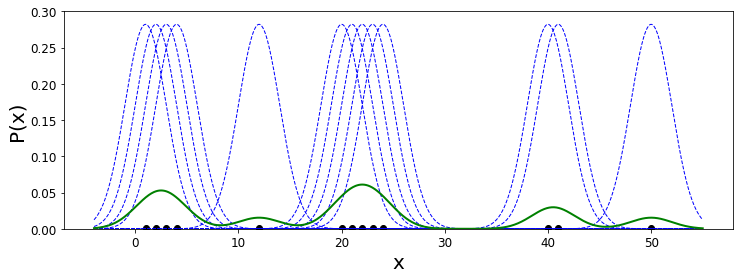

In [11]:
import numpy as np
import matplotlib.pyplot as plt

N = 20
# gera os dados
X = np.array([1, 2, 3, 4, 12, 20,21,22,23,24,40,41, 50])
X = X.reshape((len(X), 1))
# mostra os dados
plt.figure(figsize=(12,4))
plt.plot(X[:, 0], 0.001*np.ones(X.shape[0]), 'ok')

# valores x para serem usados nas densidades
X_plot = np.linspace(np.min(X)-5, np.max(X)+5, 1000)[:, np.newaxis]

h=2 
fhat = 0 # estimacao obtida
for x in X:
    # distribuição normal centrada em x
    f = (1/np.sqrt(2*np.pi*h))*np.exp(-((X_plot - x)**2)/(2*h**2))
    fhat = fhat + f # acumula as distribuições
    plt.plot(X_plot,f, '--', color = 'blue', linewidth=1)

# mostra a distribuição estimada
plt.plot(X_plot,fhat/(len(X)*np.sqrt(h)), color = 'green', linewidth=2)
plt.xlabel('x', fontsize = 20)
plt.ylabel('P(x)', fontsize = 20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim((0, 0.3))
plt.savefig('kernel-ex.eps')
plt.show(True)

Esse resultado pode ser obtido usando-se a função KernelDensity scikit-learn.

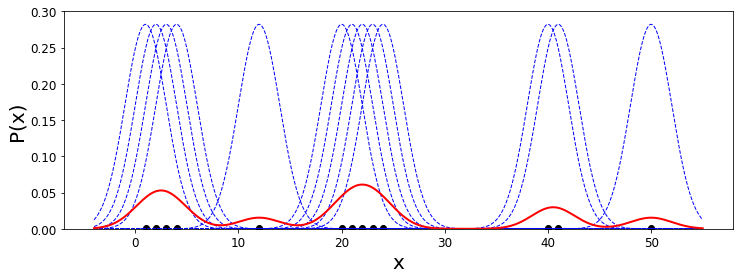

In [12]:
import numpy as np
from matplotlib.pyplot import cm
from sklearn.neighbors import KernelDensity

color=['red', 'blue', 'magenta', 'gray', 'green']

N = 20
X = np.array([1, 2, 3, 4, 12, 20,21,22,23,24,40,41, 50])
X = X.reshape((len(X), 1))

plt.figure(figsize=(12,4))
plt.plot(X[:, 0], 0.001*np.ones(X.shape[0]), 'ok')

X_plot = np.linspace(np.min(X)-5, np.max(X)+5, 1000)[:, np.newaxis]

h=2
fhat = 0
for x in X:
    f = (1/np.sqrt(2*np.pi*h))*np.exp(-((X_plot - x)**2)/(2*h**2))
    fhat = fhat + f
    plt.plot(X_plot,f, '--', color = 'blue', linewidth=1)

kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(X)
log_dens = np.exp(kde.score_samples(X_plot)) # score_samples() returns the log density.
plt.plot(X_plot,log_dens, color = 'red', linewidth=2, label = 'h='+str(h))    
plt.xlabel('x', fontsize = 20)
plt.ylabel('P(x)', fontsize = 20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim((0, 0.3))

plt.show(True)

Notem que o formato da estimação depende do parâmetro livre $h$.

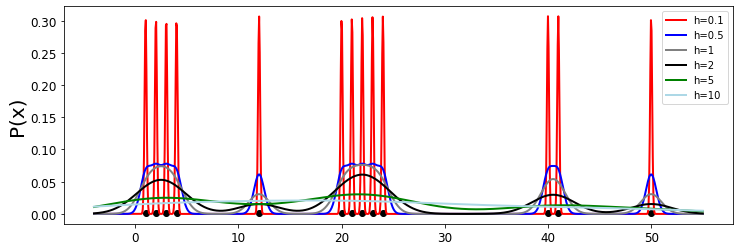

In [13]:
import numpy as np
from matplotlib.pyplot import cm

color=['red', 'blue', 'gray', 'black', 'green', 'lightblue']

N = 20
X = np.array([1, 2, 3, 4, 12, 20,21,22,23,24,40,41, 50])
X = X.reshape((len(X), 1))

X_plot = np.linspace(np.min(X)-5, np.max(X)+5, 1000)[:, np.newaxis]

plt.figure(figsize=(12,4))
plt.plot(X[:, 0], 0.001*np.ones(X.shape[0]), 'ok')
c = 0
vh = [0.1, 0.5, 1, 2, 5, 10]
for h in vh:
    kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(X)
    log_dens = np.exp(kde.score_samples(X_plot)) # score_samples() returns the log density.
    plt.plot(X_plot,log_dens, color = color[c], linewidth=2, label = 'h='+str(h))
    c = c + 1
plt.ylabel('P(x)', fontsize = 20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.ylim((0, 0.2))
plt.legend(fontsize = 10)
#plt.savefig('kernel.eps')
plt.show(True)

Notem que a estimação é relacionada com a estimação usando-se histogramas.

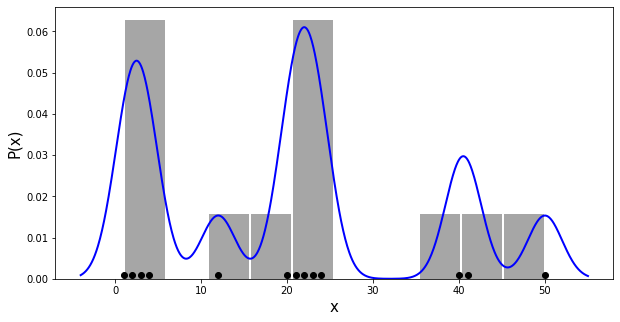

In [14]:
import numpy as np

N = 20
X = np.array([1, 2, 3, 4, 12, 20,21,22,23,24,40,41, 50])
X = X.reshape((len(X), 1))

plt.figure(figsize=(10,5))
# Histogram
nbins = 10
plt.hist(X,bins = nbins, density = True, color='gray',alpha=0.7, rwidth=0.95)

#Kernel density estimation
X_plot = np.linspace(np.min(X)-5, np.max(X)+5, 1000)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=2).fit(X)
log_dens = np.exp(kde.score_samples(X_plot)) # score_samples() returns the log density.
plt.plot(X_plot,log_dens, color = 'blue', linewidth=2)
plt.plot(X[:, 0], 0.001*np.ones(X.shape[0]), 'ok')
plt.xlabel('x', fontsize = 15)
plt.ylabel('P(x)', fontsize = 15)

plt.show(True)

Usando o método *kernel density estimation*, podemos realizar a classificação.

In [18]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity
from sklearn.metrics import accuracy_score

random.seed(42)
#data = pd.read_csv('data/Iris.csv', header=(0))
data = pd.read_csv('data/Vehicle.csv', header=(0))

classes = np.array(pd.unique(data[data.columns[-1]]), dtype=str)  

# Converte para matriz e vetor do numpy
data = data.to_numpy()
nrow,ncol = data.shape
y = data[:,-1]
X = data[:,0:ncol-1]

# Transforma os dados para terem media igual a zero e variancia igual a 1
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

# Seleciona os conjuntos de treinamento e teste
p = 0.8 # fraction of elements in the training set
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = p, random_state = 42)

# Matriz que armazena as probabilidades para cada classe
P = pd.DataFrame(data=np.zeros((x_test.shape[0], len(classes))), columns = classes) 
Pc = np.zeros(len(classes)) # Armaze a fracao de elementos em cada classe
h = 2
for i in np.arange(0, len(classes)): # Para cada classe
    elements = tuple(np.where(y_train == classes[i])) # elmentos na classe i
    Pc[i] = len(elements)/len(y_train) # Probabilidade pertencer a classe i
    Z = x_train[elements,:][0] # Elementos no conjunto de treinamento
    kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(Z)
    for j in np.arange(0,x_test.shape[0]): # para cada observacao no conjunto de teste
        x = x_test[j,:]
        x = x.reshape((1,len(x)))
        # calcula a probabilidade pertencer a cada classe
        pj = np.exp(kde.score_samples(x)) 
        P[classes[i]][j] = pj*Pc[i]
        
y_pred = [] # Vetor com as classes preditas
for i in np.arange(0, x_test.shape[0]):
    c = np.argmax(np.array(P.iloc[[i]]))
    y_pred.append(classes[c])
y_pred = np.array(y_pred, dtype=str)
# calcula a acuracia
score = accuracy_score(y_pred, y_test)
print('Acuracia:', score)

Acuracia: 0.6764705882352942


### Exercícios

1 - Considere outras distribuições na classificação dos dados, além da Normal.<br>
2 - Verifique como o parâmetro $h$ influencia na classificação.

